# Airbnb new user booking
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

In [1]:
import cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

/Users/jjl/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


1. Exploratory analysis
-----------------------

In [2]:
train = pd.read_csv('../input/train_users_2.csv')
test = pd.read_csv('../input/test_users.csv')
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
## use for spltting up combined train+test data, recording predictions
labels = train['country_destination'].values
df_train = train.drop(['country_destination'], axis=1)
df_test = test.copy()
id_test = test['id']
piv_train = train.shape[0]

In [4]:
#Creating a DataFrame with train+test data
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

#Removing id and date_first_booking
#df_all = df_all.drop(['id', 'date_first_booking'], axis=1)

# Remove date_first_booking only
# we can remove id after merging with sessions
df_all = df_all.drop(['date_first_booking'], axis=1)

#Filling nan
df_all = df_all.fillna(-1)
df_all_copy = df_all.copy()

---
** experiment with removing classes**

In [11]:
## remove top destinations
train_copy = train.copy()
holder = {}
for i in ['NDF', 'US', 'other']:
    holder[i] = train_copy[train_copy.country_destination==i]
    train_copy = train_copy[train_copy.country_destination!=i]

train_copy.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
12,k6np330cm1,2010-01-05,20100105060859,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR
15,v4d5rl22px,2010-01-07,20100107204555,2010-01-08,FEMALE,33,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,CA
19,gdka1q5ktd,2010-01-10,20100110010817,2010-01-10,FEMALE,29,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,FR
25,al8bcetz0g,2010-01-12,20100112131444,2010-01-15,FEMALE,26,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,FR
28,tp6x3md0n4,2010-01-13,20100113044650,2010-01-13,-unknown-,35,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR


In [489]:
## put train back together with reduced NDF, US, other
train_cut = pd.concat((train_copy, holder['NDF'][:2250], holder['US'][:2250], holder['other'][:2250]),
                      axis=0, ignore_index=True)
train_cut.country_destination.value_counts()

FR       5023
IT       2835
GB       2324
other    2250
US       2250
NDF      2250
ES       2249
CA       1428
DE       1061
NL        762
AU        539
PT        217
Name: country_destination, dtype: int64

---
### Look at just train users, incl sessions data

In [13]:
# Load session data
sessions = pd.read_csv('../input/sessions.csv')

# make copy of training data
users = train.copy()

In [8]:
print sessions.shape

(10567737, 6)


In [9]:
users[users.id==sessions.user_id[12]]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other


In [54]:
users.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [94]:
lookit = users[users.country_destination=='GB']
lookit[lookit.gender!='-unknown-'].tail(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
213090,e92h789jtp,2014-06-30,20140630072627,2014-06-30,FEMALE,35,basic,0,en,direct,direct,untracked,Web,iPhone,Mobile Safari,GB
213100,4ig6vxzj1d,2014-06-30,20140630082607,2014-06-30,FEMALE,38,basic,0,en,direct,direct,linked,Web,Windows Desktop,Firefox,GB
213268,gj1oghtlge,2014-06-30,20140630190808,2014-06-30,MALE,22,facebook,0,en,seo,google,untracked,Web,Windows Desktop,Chrome,GB
213287,1e71s11u3h,2014-06-30,20140630193752,2014-11-05,MALE,36,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,GB
213372,0co6s86hgb,2014-06-30,20140630215947,2015-04-13,MALE,41,facebook,0,en,other,padmapper,omg,Web,Mac Desktop,Safari,GB


In [26]:
# look at 1 user's session(s)
look_at_user = '2bvnlou71p'
print sessions[sessions.user_id== look_at_user].shape
sessions[sessions.user_id==look_at_user]

(0, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [27]:
# show user data
users[users.id=='2bvnlou71p']

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
135,2bvnlou71p,2010-02-22,20100222101428,2010-03-04,-unknown-,25,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,US


In [19]:
# look up session data by list of id's
lookit = users[users.country_destination=='US'][:]
print lookit.id.values[50:115]
sessions[sessions.user_id.isin(lookit.id.values)][:9]

['2bvnlou71p' 'p2j15lz8ge' 'mc6ihnidpc' 'qmg77g7lge' 'mcdh2s9owp'
 'ese54wmkcb' 'jad3mbqepi' 'hl3t7qzrdu' 'fyh4atoj1y' 'o9sog26g9x'
 'dstzfld8qk' 'c0unmqaa5y' '7a8k3t3zd7' '5ml3i1o90h' '1a9khjwzuh'
 'yyikx9ztzu' 'to2hnhh1bc' 'k9zs5iak6w' 'ju7u7y9bo1' 'zpfucx0ipa'
 '23czs745fi' '3rcltoc165' '1plg7bk21b' 'b9gk1av7rt' '1r5wy9nxcs'
 'fjs54jvq2s' 'v31grxlt55' 'nhusfpisf6' 'gwtsd4te19' 'i4edhlimed'
 'z4gv6bmyy7' 'vnlfsfrxzy' 'jdy1ic9k4m' 'fmss7nq5uh' 'l6b51zsk0b'
 '9pthv2dj2u' 'i40huwxnxj' '08zribz6lb' 'rqt4fs7tgv' '39zddogscp'
 '0yb3medm94' 'o2vi06sgkj' 'dey77qlhmz' 'ezkyrpdeo8' 'pyce1jzuzo'
 'nddgfoqsmc' 'lq0fec8hfd' '2fauin9rez' 'zfcvq4vj94' 'bwzhjps811'
 '8kjcxgk0sl' '0p94c49eoo' '8nwchwpq2o' 'y9lkqvfv1r' '8hou630j7f'
 'dl6lf5iqw8' 'r3i72eb2ae' '7q4lkd34g7' 'xoq994nhd4' '6wdr9zaflp'
 'myo86rnosj' 'gzlqc7mz1o' '9nf2vrjee0' 'fn9i5v97zr' '1rk8pr9sd0']


,user_id,action,action_type,action_detail,device_type,secs_elapsed
315,xwxei6hdk4,dashboard,view,dashboard,iPhone,1355
316,xwxei6hdk4,header_userpic,data,header_userpic,iPhone,1246
317,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,NaN
318,xwxei6hdk4,ask_question,submit,contact_host,iPad Tablet,386
319,xwxei6hdk4,ask_question,submit,contact_host,iPad Tablet,424
320,xwxei6hdk4,NaN,message_post,message_post,iPad Tablet,0
321,xwxei6hdk4,confirm_email,click,confirm_email_link,iPhone,46262
775,awiurksqr3,ask_question,submit,contact_host,iPad Tablet,488
776,awiurksqr3,NaN,message_post,message_post,iPad Tablet,NaN


In [29]:
df_test[df_test.id==sessions.user_id[len(sessions)-1]]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
62095,9uqfg8txu3,2014-09-30,20140930235901,NaN,FEMALE,49,basic,0,en,other,other,tracked-other,Web,Windows Desktop,Chrome


---
### Look at missing/null

In [25]:
## replace missing gender data with NaN
users.gender.replace('-unknown-', np.nan, inplace=True)

In [20]:
## compute Nan pct, users
(users.isnull().sum() / users.shape[0]) * 100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                      0.000000
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

In [153]:
## compute Nan pct, sessions
(sessions.isnull().sum() / sessions.shape[0]) * 100

user_id           0.326428
action            0.753482
action_type      10.657003
action_detail    10.657003
device_type       0.000000
secs_elapsed      1.287229
dtype: float64

In [27]:
## replace questionable age values
users.loc[users.age > 99, 'age'] = np.nan
users.loc[users.age < 10, 'age'] = np.nan

### Look at datetime cols

In [13]:
20090319043255 // 1000000

20090319

In [15]:
users['date_account_created'][:5]

0    2010-06-28
1    2011-05-25
2    2010-09-28
3    2011-12-05
4    2010-09-14
Name: date_account_created, dtype: object

In [16]:
pd.to_datetime(20140601000148, format="%Y%m%d%H%M%S") - pd.to_datetime(users['date_account_created'][0])

Timedelta('1434 days 00:01:48')

In [17]:
test = users['timestamp_first_active'][:5]//1000000
test = pd.to_datetime(test, format="%Y%m%d")
test

0   2009-03-19
1   2009-05-23
2   2009-06-09
3   2009-10-31
4   2009-12-08
Name: timestamp_first_active, dtype: datetime64[ns]

In [ ]:
## format account create date
train_data['date_account_created'] = pd.to_datetime(train_data['date_account_created'])
test_data['date_account_created'] = pd.to_datetime(test_data['date_account_created'])

In [ ]:
## format first active timestamp
train_data['timestamp_first_active'] = pd.to_datetime(train_data['timestamp_first_active']//1000000, format="%Y%m%d")
test_data['timestamp_first_active'] = pd.to_datetime(test_data['timestamp_first_active']//1000000, format="%Y%m%d")

### Look at gender

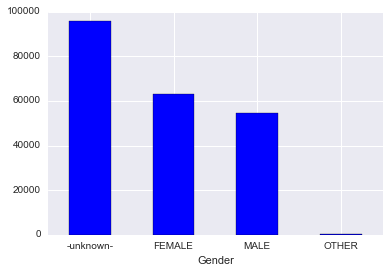

In [278]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='blue', rot=0)
plt.xlabel('Gender')
sns.despine()
plt.show()

### Look at 'country_destination' (label/target)

In [279]:
train.country_destination.value_counts()

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64

In [280]:
targets = ['IT', 'GB', 'ES', 'CA', 'DE']

In [281]:
target_set = train[train.country_destination.isin(targets)]
target_set.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
15,v4d5rl22px,2010-01-07,20100107204555,2010-01-08,FEMALE,33,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,CA
44,g3z67e37mb,2010-12-01,20100123090523,2010-12-03,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,GB
46,f6mzhb4wbc,2010-01-24,20100124002335,2010-02-25,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,ES
57,ehcdcpkn8y,2010-01-27,20100127083836,2010-01-28,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Android Tablet,Chrome,CA
63,ranh94tmin,2010-01-29,20100129182105,2010-01-29,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,CA


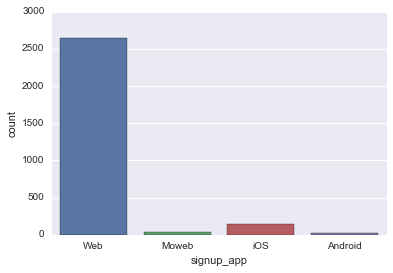

In [282]:
# targets = ['IT', 'GB', 'ES', 'CA', 'DE']
sns.countplot(x="signup_app", data=target_set[target_set.country_destination=='IT'])

/Users/jjl/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


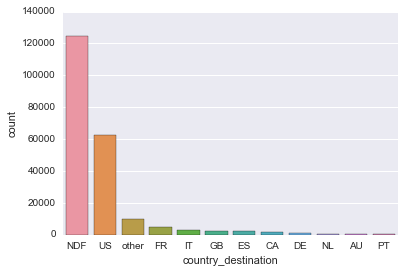

In [44]:
sns.countplot(x="country_destination", data=train, order=list(train.country_destination.value_counts().keys()))

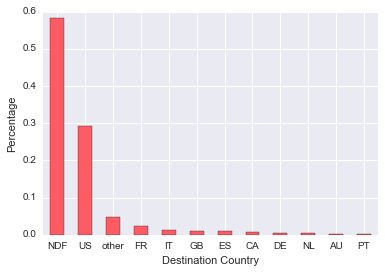

In [46]:
destination_percentage = train.country_destination.value_counts() / train.shape[0]
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)

plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

### Age

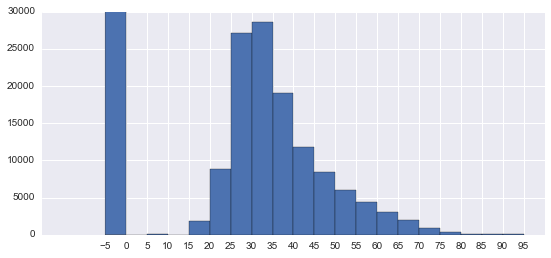

In [451]:
age_vals = train['age'].fillna(-1).values
plt.hist(age_vals, bins=range(-5,100,5))
plt.gcf().set_size_inches(9,4)
plt.xticks(range(-5,100,5))
plt.ylim(0,30000)
plt.show()

### Age/Gender buckets

In [287]:
bkts = pd.read_csv('../input/age_gender_bkts.csv')
bkts = bkts.drop('year', 1)

In [385]:
bkts.head(3)

,age_bucket,country_destination,gender,population_in_thousands
0,100+,AU,male,1
1,95-99,AU,male,9
2,90-94,AU,male,47


In [343]:
print sorted(bkts.age_bucket.unique())

['0-4', '10-14', '100+', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '5-9', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99']


In [348]:
age_order = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']

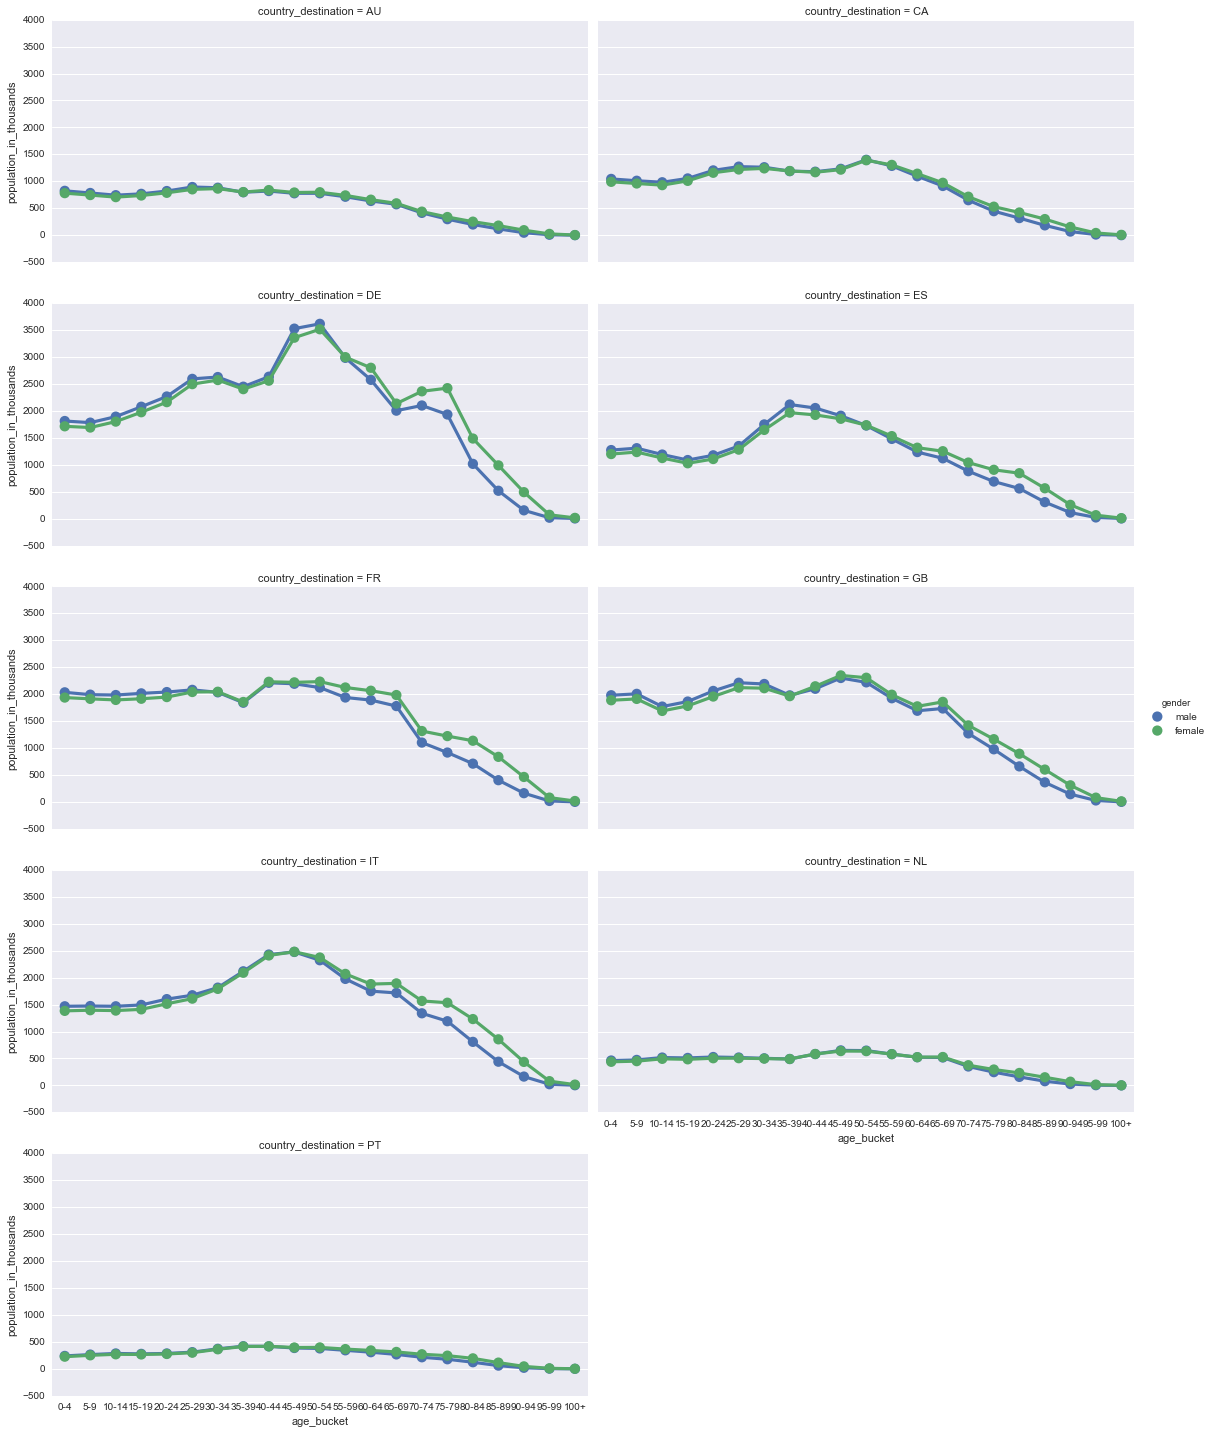

In [387]:
# top targets after NDF,US,other = ['IT', 'GB', 'ES', 'CA', 'DE']
sns.factorplot(x="age_bucket", y="population_in_thousands", \
              data=bkts[bkts.country_destination!='US'], hue='gender', \
              size=4, aspect=2, order=age_order, \
              col='country_destination', col_wrap=2)

### Convert target/label to categorical
(not in use)

In [ ]:
train_data['country_destination'] = train_data['country_destination'].astype('category')

In [ ]:
sns.set()
sns.countplot(x="country_destination", hue="gender", data=train_data, palette="Blues_d")

In [ ]:
sns.countplot(x="country_destination", hue="signup_method", data=train_data, palette="Blues_d")

In [ ]:
sns.countplot(x="country_destination", hue="affiliate_channel", data=train_data, palette="Blues_d")

In [ ]:
sns.countplot(x="country_destination", hue="first_device_type", data=train_data, palette="Blues_d")

---
2. Feature engineering
----------------------

In [5]:
# restart
df_all = df_all_copy.copy()

In [6]:
#date_account_created
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]

df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28


In [7]:
#timestamp_first_active
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]

df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9


In [8]:
## calc time diff b/w dac, tfa
dac_int = df_all.date_account_created.astype(str).apply(lambda x: int(x.translate(None, '-')))
print dac_int[:3]
tfa_int = df_all.timestamp_first_active.astype(str).apply(lambda x: int(x[:8]))
print tfa_int[:3]

0    20100628
1    20110525
2    20100928
Name: date_account_created, dtype: int64
0    20090319
1    20090523
2    20090609
Name: timestamp_first_active, dtype: int64


In [9]:
df_all['dac_tfa'] = dac_int - tfa_int
df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1,facebook,0,en,direct,direct,...,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19,10309
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38,facebook,0,en,seo,google,...,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23,20002
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56,basic,3,en,direct,direct,...,Web,Windows Desktop,IE,2010,9,28,2009,6,9,10319


In [10]:
## remove old cols
df_all = df_all.drop(['date_account_created'], axis=1)
df_all = df_all.drop(['timestamp_first_active'], axis=1)
df_all.head(3)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa
0,gxn3p5htnn,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19,10309
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23,20002
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9,10319


In [11]:
#Age
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<0, av>99), -1, av)

In [12]:
# make a copy to use later
df_all_id = df_all.copy()

### 2a. Join session data

In [90]:
look_at = '00023iyk9l'
users[users.id==look_at]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
189274,00023iyk9l,2014-05-14,20140514195452,2014-05-14,-unknown-,31,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US


In [91]:
sessions[sessions.user_id==look_at][:6]

,user_id,action,action_type,action_detail,device_type,secs_elapsed
3573923,00023iyk9l,index,view,view_search_results,Mac Desktop,20438
3573924,00023iyk9l,dashboard,view,dashboard,Mac Desktop,787
3573925,00023iyk9l,header_userpic,data,header_userpic,Mac Desktop,850
3573926,00023iyk9l,dashboard,view,dashboard,Mac Desktop,934
3573927,00023iyk9l,callback,partner_callback,oauth_response,Mac Desktop,NaN
3573928,00023iyk9l,NaN,message_post,message_post,Mac Desktop,129817


In [107]:
# look at action detail, session, user
view_detail = 'oauth_response'
print sessions[sessions.action_detail==view_detail].shape
sessions[sessions.action_detail==view_detail][1001:1006]

(19132, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
1227405,rldfom99q5,callback,partner_callback,oauth_response,Mac Desktop,2616
1227414,rldfom99q5,callback,partner_callback,oauth_response,Mac Desktop,9573
1227426,rldfom99q5,callback,partner_callback,oauth_response,Mac Desktop,2481
1227430,rldfom99q5,callback,partner_callback,oauth_response,Mac Desktop,2136
1227433,rldfom99q5,callback,partner_callback,oauth_response,Mac Desktop,16795


### ** Merge sessions 'action_detail' to df_all**

In [38]:
# count based on action/action_detail...
# action_detail== 'contact_host'
# action_type== payment_instruments, book_it
# action_type=='booking_request', .action_detail=='pending'

# 1. subset sessions to only 'pending' events
pending_uu = sessions[sessions.action_detail=='pending'].loc[:,['user_id', 'action_detail']]
pending_uu.head(3)

,user_id,action_detail
139,4grx6yxeby,pending
2340,s9xrwtyzsq,pending
2497,j0mufvhhoh,pending


In [39]:
# 2. count number of 'pending' events per user
pending_size = pending_uu.groupby( ["user_id"], as_index=False).size()
pending_size[:5]

user_id
00023iyk9l    1
006ml14zc1    1
007gj7kqdk    1
009a40t3dk    1
00bxmflswn    1
dtype: int64

In [40]:
# 3. convert size values to dataframe
pending_uu = pd.DataFrame({'pending_count' : pending_size }).reset_index()
pending_uu.head(5)

,user_id,pending_count
0,00023iyk9l,1
1,006ml14zc1,1
2,007gj7kqdk,1
3,009a40t3dk,1
4,00bxmflswn,1


In [108]:
# group sessions: action_detail, action_type, action
grouping = 'action_detail'
sess_uu = sessions.groupby(['user_id', grouping], as_index=False)

In [109]:
# count number of events per user in sessions
# 1. convert session grouping to dataframe
events_uu = pd.DataFrame({'event_count' : sess_uu.size() }).reset_index()
events_uu[10:15]

,user_id,action_detail,event_count
10,00023iyk9l,view_search_results,5
11,00023iyk9l,wishlist_content_update,4
12,00023iyk9l,your_trips,2
13,0010k6l0om,-unknown-,5
14,0010k6l0om,change_trip_characteristics,8


In [110]:
# look at common values
events_uu[grouping].value_counts()[:50]

-unknown-                        108415
p3                                94931
header_userpic                    94031
view_search_results               87640
wishlist_content_update           69096
user_profile                      57546
change_trip_characteristics       56067
create_user                       53908
dashboard                         53460
confirm_email_link                51980
message_post                      43834
similar_listings                  41353
update_listing                    31674
contact_host                      28991
login                             28620
listing_reviews                   27947
user_social_connections           27852
notifications                     25010
user_profile_content_update       24093
user_wishlists                    21628
create_phone_numbers              21391
signup                            21002
message_thread                    20030
p1                                19995
edit_profile                      19952


In [90]:
# 2. count other things
things_to_count = ['contact_host', 'your_trips', 'manage_listings', \
                   'listing_reviews', 'apply_coupon', 'post_checkout_action', \
                   'translations', 'profile_verifications', 'profile_references', \
                   'cancellation_policies'
                  ]
things_uu = events_uu[events_uu.action_detail.isin(things_to_count)]

pivot_uu = things_uu.pivot_table('event_count', ['user_id'], ['action_detail'])
pivot_uu = pd.DataFrame(pivot_uu).reset_index()
pivot_uu.head()

action_detail,user_id,apply_coupon,cancellation_policies,contact_host,listing_reviews,post_checkout_action,profile_references,profile_verifications,translations,your_trips
0,00023iyk9l,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,0028jgx1x1,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN
2,002qnbzfs5,NaN,NaN,8,10,NaN,NaN,NaN,NaN,NaN
3,0035hobuyj,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
4,00378ocvlh,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN


In [413]:
# 3. sum the event_counts
events_uu = events_uu.groupby(['user_id'], as_index=False).aggregate(np.sum)
#events_uu.columns = ['user_id', 'event_ct']
events_uu.head()

,user_id,event_count
0,00023iyk9l,37
1,0010k6l0om,48
2,001wyh0pz8,85
3,0028jgx1x1,31
4,002qnbzfs5,712


In [94]:
# 4. full outer join the session data

## add count of all events in sessions
#sessions_merge = pd.merge(left=events_uu, right=pending_uu, how='outer', left_on='user_id', right_on='user_id')
#print sessions_merge.head()

## only include 'pending' and other specified action_detail types
sessions_merge = pd.merge(left=pending_uu, right=pivot_uu, how='outer', left_on='user_id', right_on='user_id')
print sessions_merge.head()

      user_id  pending_count  apply_coupon  cancellation_policies  \
0  00023iyk9l              1           NaN                    NaN   
1  006ml14zc1              1           NaN                    NaN   
2  007gj7kqdk              1           NaN                    NaN   
3  009a40t3dk              1           NaN                    NaN   
4  00bxmflswn              1           NaN                    NaN   

   contact_host  listing_reviews  post_checkout_action  profile_references  \
0           NaN              NaN                   NaN                 NaN   
1           NaN              NaN                     1                 NaN   
2           NaN              NaN                   NaN                 NaN   
3           NaN              NaN                     1                 NaN   
4             1              NaN                     1                 NaN   

   profile_verifications  translations  your_trips  
0                    NaN           NaN           2  
1         

### Use pivot table

In [87]:
# start over with df_all
df_all = df_all_id.copy()
df_all.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa
0,gxn3p5htnn,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19,10309
1,820tgsjxq7,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23,20002
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9,10319
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5,2009,10,31,20174
4,87mebub9p4,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14,2009,12,8,9706


In [67]:
# count number of events per user in sessions
# convert session grouping to dataframe
sess_uu = sessions.groupby(['user_id', 'action_detail'], as_index=False)
events_uu = pd.DataFrame({'event_count' : sess_uu.size() }).reset_index()
events_uu[10:15]

,user_id,action_detail,event_count
10,00023iyk9l,view_search_results,5
11,00023iyk9l,wishlist_content_update,4
12,00023iyk9l,your_trips,2
13,0010k6l0om,-unknown-,5
14,0010k6l0om,change_trip_characteristics,8


In [128]:
# convert with pivot table

drop_these_events = ['-unknown-', 'user_profile', 'create_user', 'dashboard']

pivot_uu = events_uu.pivot_table('event_count', ['user_id'], ['action_detail'])
pivot_uu = pd.DataFrame(pivot_uu.fillna(0)).reset_index()
pivot_uu = pivot_uu.drop(drop_these_events, axis=1)
pivot_uu.head()

action_detail,user_id,account_notification_settings,account_payment_methods,account_payout_preferences,account_privacy_settings,account_transaction_history,admin_templates,airbnb_picks_wishlists,alteration_field,alteration_request,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,00023iyk9l,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,4,0,0,0,2
1,0010k6l0om,0,0,0,0,0,0,0,0,0,...,0,10,0,0,0,8,0,0,0,0
2,001wyh0pz8,0,0,0,0,0,0,0,0,0,...,0,66,0,0,0,0,0,0,0,0
3,0028jgx1x1,0,0,0,0,0,0,0,0,0,...,0,9,0,0,0,0,0,0,0,0
4,002qnbzfs5,0,0,0,0,0,0,0,0,0,...,0,125,0,0,0,0,0,0,0,0


### Sum up seconds elapsed per action_detail type

In [69]:
# 1/2. count secs_elapsed per action_detail
secs_uu = sess_uu.aggregate(np.sum)
secs_uu[10:15]

,user_id,action_detail,secs_elapsed
10,00023iyk9l,view_search_results,54791
11,00023iyk9l,wishlist_content_update,3515
12,00023iyk9l,your_trips,1466
13,0010k6l0om,-unknown-,123033
14,0010k6l0om,change_trip_characteristics,20110


In [70]:
# 2/2. convert with pivot table
pivot_secs = secs_uu.pivot_table('secs_elapsed', ['user_id'], ['action_detail'])
pivot_secs = pd.DataFrame(pivot_secs.fillna(0)).reset_index()
pivot_secs = pivot_secs.drop('-unknown-', axis=1)
pivot_secs.head()

action_detail,user_id,account_notification_settings,account_payment_methods,account_payout_preferences,account_privacy_settings,account_transaction_history,admin_templates,airbnb_picks_wishlists,alteration_field,alteration_request,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,00023iyk9l,0,0,0,0,0,0,0,0,0,...,0,54791,0,0,0,3515,0,0,0,1466
1,0010k6l0om,0,0,0,0,0,0,0,0,0,...,0,75951,0,0,0,135661,0,0,0,0
2,001wyh0pz8,0,0,0,0,0,0,0,0,0,...,0,158796,0,0,0,0,0,0,0,0
3,0028jgx1x1,0,0,0,0,0,0,0,0,0,...,0,199802,0,0,0,0,0,0,0,0
4,002qnbzfs5,0,0,0,0,0,0,0,0,0,...,0,493417,0,0,0,0,0,0,0,0


In [129]:
# merge the event count w/ secs elapsed
sessions_merge = pd.merge(left=pivot_uu, right=pivot_secs, how='outer', left_on='user_id', right_on='user_id')
sessions_merge = sessions_merge.fillna(0)
sessions_merge.head()

action_detail,user_id,account_notification_settings_x,account_payment_methods_x,account_payout_preferences_x,account_privacy_settings_x,account_transaction_history_x,admin_templates_x,airbnb_picks_wishlists_x,alteration_field_x,alteration_request_x,...,view_resolutions_y,view_search_results_y,view_security_checks_y,view_user_real_names_y,wishlist_y,wishlist_content_update_y,wishlist_note_y,your_listings_y,your_reservations_y,your_trips_y
0,00023iyk9l,0,0,0,0,0,0,0,0,0,...,0,54791,0,0,0,3515,0,0,0,1466
1,0010k6l0om,0,0,0,0,0,0,0,0,0,...,0,75951,0,0,0,135661,0,0,0,0
2,001wyh0pz8,0,0,0,0,0,0,0,0,0,...,0,158796,0,0,0,0,0,0,0,0
3,0028jgx1x1,0,0,0,0,0,0,0,0,0,...,0,199802,0,0,0,0,0,0,0,0
4,002qnbzfs5,0,0,0,0,0,0,0,0,0,...,0,493417,0,0,0,0,0,0,0,0


### PCA reduced sessions

In [ ]:
# TODO: keep user id sepearate
pivot_ids = pivot_uu['user_id']
pivot_uu = pivot_uu.drop('user_id', axis=1)

In [143]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=30, copy=True, whiten=False)

# fit the data
pca.fit(pivot_uu)

# Print the components and the amount of variance in the data contained in each dimension
print sum(pca.explained_variance_ratio_)
pca.explained_variance_ratio_

0.994647860711


array([  4.55784016e-01,   1.76720370e-01,   1.34333992e-01,
         1.04366961e-01,   4.46364281e-02,   2.29000872e-02,
         9.85413653e-03,   8.33610964e-03,   7.09086715e-03,
         4.94513283e-03,   3.90182942e-03,   3.07658093e-03,
         2.37547336e-03,   1.89985253e-03,   1.64290753e-03,
         1.59587043e-03,   1.49620374e-03,   1.31682851e-03,
         1.11501027e-03,   1.08507240e-03,   9.01577834e-04,
         8.74137626e-04,   7.94024601e-04,   7.27729297e-04,
         6.59200877e-04,   5.53850220e-04,   4.53780643e-04,
         4.39955814e-04,   4.01040885e-04,   3.68832672e-04])

In [144]:
events_pca = pca.transform(pivot_uu)
print events_pca.shape

(135478, 30)


In [162]:
sessions_merge = pd.concat((pd.DataFrame(events_pca), pivot_ids), axis=1)
sessions_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,user_id
0,-11.552858,4.563340,-4.783074,1.423241,-0.482374,1.426581,-0.305765,-0.370464,-0.232111,-1.206425,...,0.314600,-0.434894,2.617254,1.029291,-0.037263,0.281922,0.084339,-0.141330,0.170418,00023iyk9l
1,-1.696191,3.084447,-4.693928,5.745356,-0.465075,1.943602,-1.864972,3.124069,0.138877,3.662305,...,0.043853,-0.266465,-0.461326,-0.394993,0.171884,0.112885,0.015717,0.093282,-0.176547,0010k6l0om
2,30.387948,29.140816,24.023564,-17.856232,-16.147731,-0.258195,0.627195,-3.518666,1.841621,-0.190239,...,-0.196947,-0.286164,-0.169058,0.079312,-0.416128,-0.007227,-0.167309,0.093205,-0.071878,001wyh0pz8
3,-6.891381,0.613752,-4.639629,-5.676685,-3.519701,1.321304,-0.287688,0.325089,-3.123836,-0.356795,...,-0.257453,0.636374,-0.187680,0.239828,-0.803435,0.009918,-0.499276,-0.008971,0.014002,0028jgx1x1
4,151.617184,-120.531591,143.144478,-40.109561,4.322015,13.913673,0.520738,-4.011590,6.561841,3.298432,...,6.185851,24.327351,-6.071458,14.120418,-9.333167,0.802146,-1.583475,-1.613278,4.330721,002qnbzfs5


### Merge sessions with df_all

In [140]:
## 5. left join sessions data to df_all
merged_left = pd.merge(left=df_all_id,right=pivot_uu, how='left', left_on='id', right_on='user_id')
merged_left[merged_left.id=='00023iyk9l']

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
189274,00023iyk9l,-unknown-,31,basic,0,en,direct,direct,omg,Web,...,0,5,0,0,0,4,0,0,0,2


In [141]:
#Removing id
df_all = merged_left.drop(['id', 'user_id'], axis=1)

# fill in any nulls after the left join
df_all = df_all.fillna(0)
df_all.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,-unknown-,-1,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,0,0,0,0,0,0,0,0,0
1,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,...,0,0,0,0,0,0,0,0,0,0
2,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,...,0,0,0,0,0,0,0,0,0,0
3,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,0,0,0,0,0,0,0,0,0
4,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,...,0,0,0,0,0,0,0,0,0,0


In [142]:
#One-hot-encoding features
''' help(pd.get_dummies)'''
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', \
             'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

In [143]:
# dont use 'first_browser' as feature
#df_all = df_all.drop(['first_browser'], axis=1)
df_all.head(3)

,age,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day,dac_tfa,account_notification_settings,account_payment_methods,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,-1,2010,6,28,2009,3,19,10309,0,0,...,0,0,0,0,0,0,0,0,0,0
1,38,2011,5,25,2009,5,23,20002,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56,2010,9,28,2009,6,9,10319,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
#Splitting train and test
vals = df_all.values
X = vals[:piv_train]
X_test_submit = vals[piv_train:]

#http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()
y = le.fit_transform(labels)

** PCA-reduced data**

In [ ]:
#Splitting train and test with PCA-reduced data
vals = pd.DataFrame(pca.transform(df_all)).values
X = vals[:piv_train]
X_test_submit = vals[piv_train:]

#http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
le = LabelEncoder()
y = le.fit_transform(labels)

---
### Normalize features

In [321]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = (feature_matrix - norms/2) / norms
        
    return(normalized_features, norms)

In [322]:
#Splitting train and test and normalizing
vals_norm,_ = normalize_features(vals)
X_norm = vals_norm[:piv_train]
X_test_norm = vals_norm[piv_train:]

In [323]:
print X_norm.shape
print X_test_norm.shape

(213451, 316)
(62096, 316)


### Convert to categoricals
(not in use)

In [ ]:
convert_to_cat = ['gender', 'age', 'signup_method', 'signup_flow', 'language', \
                  'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', \
                  'signup_app', 'lang_app', 'first_device_type', 'first_browser']

In [ ]:
## factorize
for i in convert_to_cat:
    Xtrain.loc[:,i] = pd.factorize(Xtrain[i])[0]
    Xtest.loc[:,i] = pd.factorize(Xtest[i])[0]

In [ ]:
## categoricals
for i in convert_to_cat:
    Xtrain.loc[:,i] = Xtrain[i].astype('category', ordered=False)
    Xtest.loc[:,i] = Xtest[i].astype('category', ordered=False)

In [ ]:
Xtrain['lang_app'].head()

In [ ]:
Xtrain['gender'] = Xtrain.age.fillna('unknown')
Xtest['gender'] = Xtest.age.fillna('unknown')

In [ ]:
Xtrain['age'] = Xtrain.age.fillna(0)
Xtest['age'] = Xtest.age.fillna(0)

---

Split train data further into train/validation/test sets
---------------

In [36]:
from sklearn import cross_validation

** convert labels to vector**

In [230]:
y_copy = y.copy()
print y_copy.shape

(213451,)


In [232]:
# reformat labels as vector
def reformat(labels, num_labels=12):
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)  # convert label to vector
  return labels

In [233]:
## variable for new label vectors
y_vec = reformat(y_copy)
print y_vec.shape

(213451, 12)


In [237]:
## keep copy of X_test_submit
X_test_copy = X_test_submit.copy()
#X_test_submit = X_test_copy.copy()

In [329]:
## convert test submission dtype
X_test_submit = X_test_norm.astype('float32')

In [330]:
## split normalized data into train and test
X_tv, X_test, y_tv, y_test = cross_validation.train_test_split(X_norm.astype('float32'), \
                                                               y_vec.astype('float32'), test_size=.05, random_state=205)

X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X_tv, y_tv, \
                                                                       test_size=.05, random_state=71511)

In [156]:
## split into train and validation
## use X,y for full training data
X_train, X_valid, y_train, y_valid = cross_validation.train_test_split(X, y, \
                                                                       test_size=.02, random_state=21116)

## Grid search
http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

In [102]:
from sklearn import metrics
from sklearn import grid_search

## Make scorer
acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, average='weighted')

### i. Random forest
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [301]:
## create cv search objec
from sklearn.ensemble import RandomForestClassifier
'''
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, \
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, \
                            max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, \
                            n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
'''
clf = RandomForestClassifier(n_estimators=100)
est = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced')
parameters = {'min_samples_split': [2,50],
              'max_depth': [100, 500],
              'class_weight': [None, 'balanced']
             }
reg = grid_search.GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5)

### ii. SVM
http://scikit-learn.org/stable/modules/svm.html

In [ ]:
from sklearn import svm
# Setup a Classifier
clf = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, \
                  shrinking=True, probability=False, tol=0.001, cache_size=200, \
                  class_weight='balanced', verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
# tune parameter with at least 3 settings
parameters = {'C': (1.0, 0.2),
             }

In [ ]:
## PCA reduced data
X_reduced = pca.transform(X)
X_test_reduced = pca.transform(X_test)

### iii. XGBoost
https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/sklearn.py

In [157]:
#Classifier
# try using... objective: multi:softprob, rank:pairwise
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
est = XGBClassifier(max_depth=8, learning_rate=0.15, n_estimators=100,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=.6, seed=None)                  

param = {
    'objective':'multi:softprob',                    
    'max_depth':6, 
    'learning_rate':0.25, 
    'n_estimators':43,                 
    'subsample':0.6, 
    'colsample_bytree':0.6,
    'num_class' :12
    }

In [158]:
eval_set = [(X_train,y_train), (X_valid,y_valid)]

In [159]:
# try using... eval_metric: mlogloss, merror, ndcg@n-
est.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=30, eval_metric='merror')

Will train until validation_1 error hasn't decreased in 30 rounds.
[0]	validation_0-merror:0.366510	validation_1-merror:0.373536
[1]	validation_0-merror:0.357819	validation_1-merror:0.361593
[2]	validation_0-merror:0.353589	validation_1-merror:0.362295
[3]	validation_0-merror:0.352628	validation_1-merror:0.362295
[4]	validation_0-merror:0.353684	validation_1-merror:0.361124
[5]	validation_0-merror:0.349826	validation_1-merror:0.356440
[6]	validation_0-merror:0.348559	validation_1-merror:0.357611
[7]	validation_0-merror:0.348387	validation_1-merror:0.358080
[8]	validation_0-merror:0.347919	validation_1-merror:0.356440
[9]	validation_0-merror:0.347221	validation_1-merror:0.356674
[10]	validation_0-merror:0.346623	validation_1-merror:0.355035
[11]	validation_0-merror:0.346007	validation_1-merror:0.354333
[12]	validation_0-merror:0.345634	validation_1-merror:0.355269
[13]	validation_0-merror:0.345180	validation_1-merror:0.354098
[14]	validation_0-merror:0.344415	validation_1-merror:0.35316

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.15, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=None, silent=True, subsample=0.6)

** Best with multi:softprob...**

    [99]	validation_0-merror:0.327157	validation_1-merror:0.348712
    
    [99]	validation_0-mlogloss:1.002152	validation_1-mlogloss:1.015543



### iii(b). XGBoost using ndcg scorer

In [364]:
"""Metrics to compute the model performance."""
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [373]:
# define cv scorer and fit the model
kf = cross_validation.KFold(len(X), n_folds=3, random_state=208)
score = cross_validation.cross_val_score(est, X, y, cv=kf, scoring=ndcg_scorer)

**Save model for later**

In [161]:
# save the classifier
with open('my_xgb_10.pkl', 'wb') as f:
    cPickle.dump(est, f)    

In [205]:
# load it again
with open('my_xgb_4.pkl', 'rb') as f:
    xgb_loaded = cPickle.load(f)

In [206]:
est = xgb_loaded

3. Fit the data
---------------

In [302]:
reg = grid_search.GridSearchCV(clf, parameters, scoring=acc_scorer, cv=3)

In [64]:
## fit with one-hot-encoded features
est.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [303]:
## fit data with all features
reg.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 50], 'max_depth': [100, 500], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [ ]:
## PCA reduced data
#reg.fit(Xtrain_trans, ytrain)
#reg.fit(X_reduced, y)

In [304]:
## get the best predictor
est = reg.best_estimator_
est

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=500, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [499]:
## predict classes
ypred = est.predict(X)

In [306]:
## predict class probabilities
ypred_prob = est.predict_proba(X)
print ypred_prob.shape

(213451, 12)


In [307]:
pd.DataFrame(ypred_prob).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000954,0.010255,0.007904,0.026183,0.023971,0.031288,0.011800,0.445771,0.006149,0.000000,0.404474,0.031252
1,0.001438,0.013102,0.011567,0.013434,0.030145,0.015466,0.016258,0.446848,0.002982,0.001418,0.403865,0.043477
2,0.005478,0.014037,0.009801,0.032260,0.069843,0.014694,0.034280,0.205136,0.004778,0.008371,0.545996,0.055326
3,0.008240,0.004046,0.001791,0.005977,0.028253,0.010616,0.022823,0.312373,0.002368,0.006717,0.279320,0.317476
4,0.001972,0.018881,0.011061,0.012600,0.050117,0.011571,0.010311,0.231436,0.002920,0.002114,0.600914,0.046104


### 3b. Keep 1-5 predicted classes with highest probability

In [162]:
## predict test, class probabilities
ypred_submit = est.predict_proba(X_test_submit)
print ypred_submit.shape

(62096, 12)


In [163]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]  # placeholder for current id in the loop
    ids += [idx] * 5  # add 5-element list with current id
    ## convert back to original labels for submissions
    cts += le.inverse_transform(np.argsort(ypred_submit[i])[::-1])[:5].tolist()
    
print len(ids)
print len(cts)

310480
310480


---
** Previous best**

          0       0.73      1.00      0.84       539
          1       0.63      0.99      0.77      1428
          2       0.70      1.00      0.82      1061
          3       0.66      0.99      0.79      2249
          4       0.72      0.97      0.83      5023
          5       0.65      0.98      0.78      2324
          6       0.63      0.98      0.77      2835
          7       0.97      0.91      0.94    124543
          8       0.62      1.00      0.76       762
          9       0.60      1.00      0.75       217
         10       0.95      0.92      0.94     62376
         11       0.77      0.95      0.85     10094

In [500]:
print metrics.classification_report(y, ypred)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       539
          1       0.00      0.00      0.00      1428
          2       0.00      0.00      0.00      1061
          3       0.00      0.00      0.00      2249
          4       1.00      0.00      0.00      5023
          5       0.00      0.00      0.00      2324
          6       1.00      0.00      0.00      2835
          7       0.70      0.86      0.77    124543
          8       0.00      0.00      0.00       762
          9       0.00      0.00      0.00       217
         10       0.51      0.50      0.50     62376
         11       0.92      0.00      0.00     10094

avg / total       0.64      0.65      0.60    213451



---
iv. Tensorflow
----------

> **1-2 hidden layers **<br>
> steps 5001, L2 reg .001, hidden 1024, rate (.5, 1000, .8), Test accuracy: **58.78**%<br>
> steps 9001, L2 reg .001, hidden 1024x500, keep .9, rate (.05 adagrad), Test accuracy: **58.78**%<br>
> steps 9001, L2 reg .001, hidden 1024x300, keep 1., rate (.01 adagrad), Test accuracy: **58.17**%<br>

> **1-2 hidden layers, init low w, b**<br>
> steps 5001, L2 reg .0002, hidden 1024x500, keep 1., rate (.1 adagrad), Test accuracy: **58.78**%<br>

> **3 hidden layers **<br>
> steps 9001, L2 reg .001, hidden 1024x300x50, rate (.01 adagrad), Test accuracy: **58.17**%<br>

> **PCA 40 dims **<br>
> steps 9001, L2 reg .001, hidden 1024x300x50, rate (.01 adagrad), Test accuracy: **58.17**%<br>

> **107 features (del 'first_browser') **<br>
> steps 5001, L2 reg .0002, hidden 1024x300x50, rate (.1 adagrad), Test accuracy: **58.04**%<br>

In [244]:
import tensorflow as tf

In [245]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [260]:
def weight_variable(shape, stddev=0.1):
  initial = tf.truncated_normal(shape, stddev=stddev)
  return tf.Variable(initial)

def bias_variable(shape, constant=0.):
  initial = tf.constant(constant, shape=shape)
  return tf.Variable(initial)

** Build graph**

In [248]:
print X_train.shape
print X_train.dtype
print X_valid.shape
print X_test.shape
print y_train[:3]
print y_train.shape
print y_valid.shape
print y_test.shape

print X_test_submit.shape

(192639, 316)
float32
(10139, 316)
(10673, 316)
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
(192639, 12)
(10139, 12)
(10673, 12)
(62096, 316)


In [331]:
reg_L2 = 0.0002
batch_size = 128
num_hidden_1 = 1024
#num_hidden_2 = 300
#num_hidden_3 = 50
num_features = X_train.shape[1]
num_labels = 12

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, num_features))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(X_valid)
  tf_test_dataset = tf.constant(X_test)
  tf_test_submit = tf.constant(X_test_submit)
  
  # Variables.
  w = weight_variable(shape=[num_features, num_hidden_1])
  b = bias_variable(shape=[num_hidden_1])

  #w2 = weight_variable(shape=[num_hidden_1, num_hidden_2])
  #b2 = bias_variable(shape=[num_hidden_2])

  #w3 = weight_variable(shape=[num_hidden_2, num_hidden_3])
  #b3 = bias_variable(shape=[num_hidden_3])

  w4 = weight_variable(shape=[num_hidden_1, num_labels])
  b4 = bias_variable(shape=[num_labels])
  
  # Training computation.
  def model(data):
    h = tf.nn.relu(tf.matmul(data, w) + b)
    ##Dropout
    keep_prob = tf.constant(1.)
    #h2 = tf.tanh(tf.matmul(h, w2) + b2)
    #h2_drop = tf.nn.dropout(h2, keep_prob)
    #h3 = tf.tanh(tf.matmul(h2, w3) + b3)
    #h3_drop = tf.tanh(tf.matmul(h2_drop, w3) + b3)
    #h3_drop = tf.nn.dropout(h3_drop, keep_prob)
    h4 = tf.matmul(h, w4) + b4
    return h4
  
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # L2 regularization for the fully connected parameters.
  #regularizers = tf.nn.l2_loss(w) + tf.nn.l2_loss(w4)
  # Add the regularization term to the loss.
  #loss += reg_L2 * 0.5 * regularizers
  
  # Optimizer.
  ## with learning rate decay
  ##global_step = tf.Variable(0, trainable=False) # count the number of steps taken.
  ##learning_rate = tf.train.exponential_decay(1., global_step, 500, 0.6, staircase=False)
  ##optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  optimizer = tf.train.AdagradOptimizer(.01).minimize(loss)
  
  # Predictions for the training, validation, test, and test submission data.
  def predict(data):
    h = tf.nn.relu(tf.matmul(data, w) + b)
    #h2 = tf.tanh(tf.matmul(h, w2) + b2)
    #h3 = tf.tanh(tf.matmul(h2, w3) + b3)
    h4 = tf.matmul(h, w4) + b4
    return h4
  train_prediction = tf.nn.softmax(predict(tf_train_dataset))
  valid_prediction = tf.nn.softmax(predict(tf_valid_dataset))
  test_prediction = tf.nn.softmax(predict(tf_test_dataset))

  submit_prediction = tf.nn.softmax(predict(tf_test_submit))

** Run it**

In [332]:
num_steps = 3001
    
def step_eval():
  for step in xrange(num_steps):
    offset = (step * batch_size) % (y_train.shape[0] - batch_size)
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = y_train[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 300 == 0):
      #print global_step.eval(), learning_rate.eval()
      print "Minibatch loss at step", step, ":", l
      print "Minibatch accuracy: %.2f%%" % accuracy(predictions, batch_labels)
      accuracy_valid = accuracy(valid_prediction.eval(), y_valid)
      print "Validation accuracy: %.2f%%" % accuracy_valid
      print "-" * 20
      if accuracy_valid > 92.:
        print "Halted!"
        return
    if (step % 1000 == 0):
      print "Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), y_test)
      print "=" * 20

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print "Initialized\n", "="*12
  step_eval()
  print "Test accuracy: %.2f%%" % accuracy(test_prediction.eval(), y_test)
  ypred_submit = submit_prediction.eval()

Initialized
Minibatch loss at step 0 : 3.26455
Minibatch accuracy: 2.34%
Validation accuracy: 58.53%
--------------------
Test accuracy: 58.78%
Minibatch loss at step 300 : 1.16833
Minibatch accuracy: 58.59%
Validation accuracy: 58.53%
--------------------
Minibatch loss at step 600 : 1.36942
Minibatch accuracy: 64.06%
Validation accuracy: 58.53%
--------------------
Minibatch loss at step 900 : 1.13909
Minibatch accuracy: 57.81%
Validation accuracy: 58.53%
--------------------
Test accuracy: 58.78%
Minibatch loss at step 1200 : 1.11844
Minibatch accuracy: 61.72%
Validation accuracy: 58.53%
--------------------
Minibatch loss at step 1500 : 1.03941
Minibatch accuracy: 64.06%
Validation accuracy: 58.53%
--------------------


KeyboardInterrupt: 

In [144]:
check = ypred_submit[2000:2004]
print check
print np.argsort(check)
for i in xrange(len(check)):
    print le.inverse_transform(np.argsort(check[i])[::-1]).tolist()

[[ 0.00275282  0.00670136  0.00510201  0.00973255  0.02230456  0.01001685
   0.01413022  0.57495332  0.00390214  0.00101802  0.30211538  0.04727076]
 [ 0.00274651  0.00668118  0.00512046  0.00975334  0.02227283  0.01004198
   0.01409889  0.57516688  0.00390226  0.00101752  0.30192763  0.04727058]
 [ 0.00273304  0.00665983  0.00510894  0.00972562  0.02229475  0.01000752
   0.01408009  0.57545155  0.00389516  0.00101317  0.30179265  0.04723767]
 [ 0.00274596  0.00669436  0.00510876  0.00974156  0.02229444  0.01002662
   0.01412156  0.57517922  0.0039057   0.00101715  0.30187249  0.04729211]
 [ 0.00274236  0.00668534  0.00511654  0.00977065  0.0222552   0.01004988
   0.01410146  0.57546836  0.00390035  0.00101695  0.30169925  0.0471937 ]]
[[ 9  0  8  2  1  3  5  6  4 11 10  7]
 [ 9  0  8  2  1  3  5  6  4 11 10  7]
 [ 9  0  8  2  1  3  5  6  4 11 10  7]
 [ 9  0  8  2  1  3  5  6  4 11 10  7]
 [ 9  0  8  2  1  3  5  6  4 11 10  7]]
['NDF', 'US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE',

---


4. Generate submission, predict the test set
--------------------------------------------

** old**

In [ ]:
# make prediction on test set
ypred = est.predict(X_test_submit)

In [ ]:
csv = pd.DataFrame({'id': test_data['id'],'country': ypred})
len(csv)

In [ ]:
# save prediction to csv file
# numpy.savetxt("foo.csv", a, delimiter=",")
csv.to_csv(path_or_buf='rf_age_20160120.csv', sep=',', na_rep='', float_format=None, columns=None, \
                 header=True, index=False, index_label=None, mode='w', encoding=None, \
                 compression=None, quoting=None, quotechar='"', line_terminator='\n', \
                 chunksize=None, tupleize_cols=False, date_format=None, doublequote=True, \
                 escapechar=None, decimal='.') 

** NEW **

In [29]:
#Taking the 1-5 classes with highest probabilities
print ypred_submit.shape  ## (62096, 12)

ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 4
    cts += le.inverse_transform(np.argsort(ypred_submit[i])[::-1])[:4].tolist()
    
print len(ids)  ## ... 310480
print len(cts)  ## ... 310480

(62096, 12)
248384
248384


In [164]:
# Generate submission
# stack ids and countries together into dataframe
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
# write dataframe to csv
sub.to_csv('../submit/xgb10_20160211.csv',index=False)

---
# Scratchpad

** PCA**

In [185]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=30, copy=True, whiten=False)

# fit the data
pca.fit(df_all)

# Print the components and the amount of variance in the data contained in each dimension
print sum(pca.explained_variance_ratio_)
pca.explained_variance_ratio_

0.999917877712


array([  9.78861744e-01,   6.74757347e-03,   4.51010295e-03,
         2.61483665e-03,   1.98095652e-03,   1.66506037e-03,
         1.53418838e-03,   6.61320886e-04,   3.38065198e-04,
         1.94961323e-04,   1.45336585e-04,   1.21470520e-04,
         1.04067974e-04,   7.31320630e-05,   5.74512220e-05,
         4.52821950e-05,   3.51608873e-05,   2.81331481e-05,
         2.43653284e-05,   2.38319003e-05,   2.21391741e-05,
         1.95618464e-05,   1.76877680e-05,   1.65547070e-05,
         1.60630892e-05,   1.33524260e-05,   1.29397120e-05,
         1.18637233e-05,   1.07646724e-05,   9.90932673e-06])

In [ ]:
## convert categoricals to int
for i in convert_to_cat:
    Xtrain.loc[:,i] = Xtrain[i].astype(int)
    Xtest.loc[:,i] = Xtest[i].astype(int)

In [ ]:
# Merge train and test users
Xall = pd.concat((Xtrain, Xtest), axis=0, ignore_index=True)
Xall.head()

In [ ]:
transformed_data = pd.DataFrame(pca.transform(df_all))
sns.set()
sns.pairplot(transformed_data)

In [ ]:
Xtrain_trans = pd.DataFrame(pca.transform(Xtrain))
Xtest_trans = pd.DataFrame(pca.transform(Xtest))

In [ ]:
train_all = pd.concat((Xtrain_trans, ytrain), axis=1, ignore_index=True)

In [ ]:
sns.stripplot(x=2, y=0, data=train_all)